In [51]:
import os

os.environ['DDE_BACKEND'] = 'tensorflow'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(42)
np.random.seed(42)

from deepxde.data import PDE
from deepxde.geometry import TimeDomain
from deepxde.icbc.initial_conditions import IC
from deepxde.icbc import PointSetBC
from deepxde.nn import FNN, PFNN
from deepxde.model import Model
from deepxde.callbacks import VariableValue, EarlyStopping
from deepxde.metrics import mean_squared_error, l2_relative_error
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

from tensorflow.keras.optimizers.schedules import InverseTimeDecay

Set the default float type to float64


In [31]:


def sir_system(t, compartments, gamma):
    S, I, R = compartments
    return [
        -beta_t(t) * S * I,
        beta_t(t) * S * I - gamma * I,
        gamma * I
    ]

In [32]:
t0, tf = 0, 50
beta_t = lambda t: t**2 / 10000 + 0.5
gamma = 0.2 
S0, I0, R0 = 0.99, 0.01, 0.0

In [33]:
sir_sol = solve_ivp(
    sir_system,
    [t0, tf],
    [S0, I0, R0],
    args=[gamma],
    dense_output=True
)

nop_data = 100
train_t = np.linspace(t0, tf, nop_data)
sir_data = sir_sol.sol(train_t).T

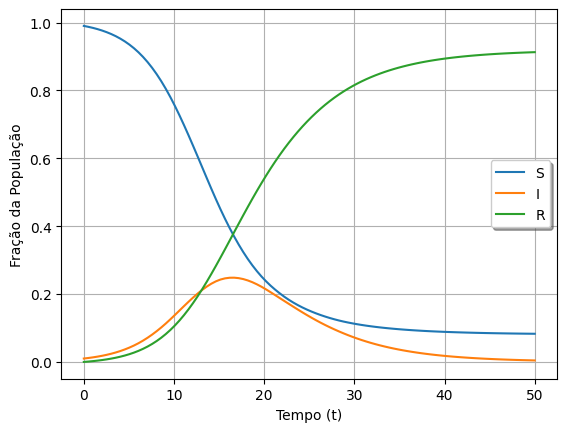

In [34]:
plt.plot(train_t, sir_data)
plt.legend(["S", "I", "R"], shadow=True)
plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")
plt.grid()
plt.savefig("../../images/rk-compartments-mono-beta-dfe.png")
plt.show()

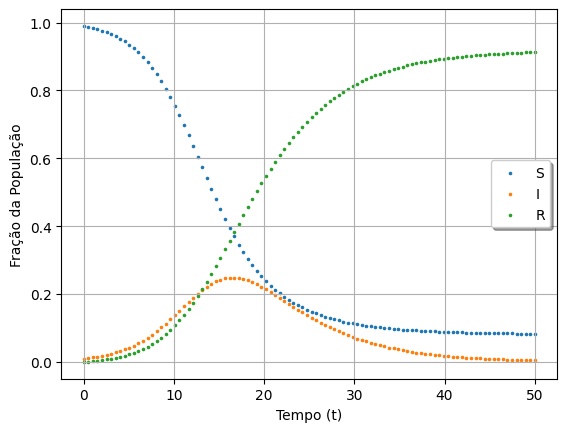

In [35]:
plt.scatter(train_t, sir_data[:, 0], s=2.5)
plt.scatter(train_t, sir_data[:, 1], s=2.5)
plt.scatter(train_t, sir_data[:, 2], s=2.5)
plt.legend(["S", "I", "R"], shadow=True)
plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")
plt.grid()
plt.savefig("../../images/rk-data-mono-beta-dfe.png")
plt.show()

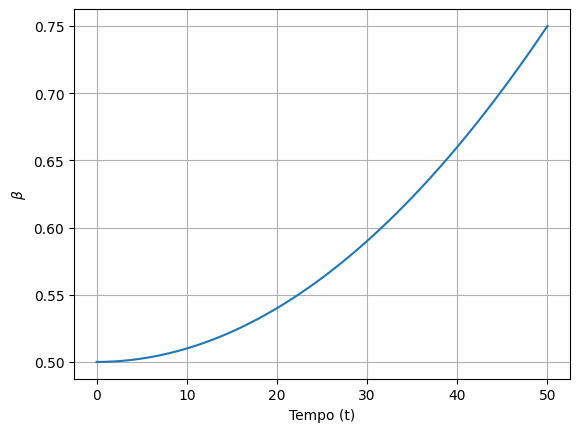

In [36]:

plt.plot(train_t, beta_t(train_t))
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.grid()
plt.savefig("../../images/real-beta-mono-beta-dfe.png")
plt.show()

In [ ]:
timeinterval = TimeDomain(t0, tf)

def sir_residual(t, y):
    S, I, beta = y[:,0:1], y[:,1:2], y[:,2:3]

    dS_dt = dde.gradients.jacobian(y, t, i=0)
    dI_dt = dde.gradients.jacobian(y, t, i=1)
    
    return [
        dS_dt + beta * S * I,
        dI_dt - beta * S * I + gamma * I
    ]

# Tensorflow has an issue with lambdas...
def is_on_initial(_, on_initial): return on_initial
def S0_val(_): return S0
def I0_val(_): return I0

ic_S = IC(timeinterval, S0_val, is_on_initial, component=0)
ic_I = IC(timeinterval, I0_val, is_on_initial, component=1)

data_t = train_t.reshape(-1, 1)
data_I = PointSetBC(data_t, sir_data[:,1:2], component=1)

ics = [ic_S, ic_I]
data_conds = [data_I] 
conditions = ics + data_conds

data = PDE(
    timeinterval, 
    sir_residual, 
    conditions,
    num_domain=128,
    num_boundary=2,
    num_test=32,
    anchors=data_t
)

n_hidden_layers = 4
hidden_layer_size = 50
topology = [1] + [hidden_layer_size] * n_hidden_layers + [3]

activation = "tanh"
initializer = "Glorot normal"

optimizer = "adam"
lr = 0.002

eq_w = 1
ic_w = 1
data_w = 1

loss_weights = [eq_w] * 2 + [ic_w] * len(ics) + [data_w] * len(data_conds)

# net = FNN(
#     topology, 
#     activation, 
#     initializer
# )

net = PFNN(
    topology, 
    activation, 
    initializer
)

model = Model(data, net)

model.compile(
    optimizer, 
    lr,
    loss_weights=loss_weights
)


2025-11-20 15:06:58.657277: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1763662018.658505  276155 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1923 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Compiling model...
'compile' took 0.043704 s



In [38]:
early_stopping = EarlyStopping(min_delta=1e-5, patience=5000)

losshistory, train_state = model.train(
    iterations=250000, 
    display_every=100,
    # callbacks=[early_stopping]
)

# model.compile(
#     "L-BFGS", 
#     loss_weights=loss_weights
# )

# dde.optimizers.set_LBFGS_options(
#     # ftol=np.finfo(float).eps,
#     maxiter=25000,
#     ftol=1e-10,
#     gtol=1e-12
# )

# losshistory, train_state = model.train(
#     iterations=20000, 
#     display_every=100
# )

Training model...



2025-11-20 15:07:03.012605: I external/local_xla/xla/service/service.cc:163] XLA service 0x561c070f4080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-20 15:07:03.012624: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-11-20 15:07:03.042205: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-20 15:07:03.164135: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1763662023.549317  276155 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                            Test loss                                             Test metric
0         [3.45e-02, 1.08e-01, 9.80e+00, 1.00e-03, 3.44e-01]    [8.84e-03, 9.24e-02, 9.80e+00, 1.00e-03, 3.44e-01]    []  
100       [4.13e-04, 4.87e-04, 1.28e-05, 4.70e-05, 3.44e-03]    [1.13e-04, 4.81e-04, 1.28e-05, 4.70e-05, 3.44e-03]    []  
200       [2.17e-04, 3.43e-04, 1.77e-09, 7.71e-08, 1.18e-03]    [1.12e-04, 3.45e-04, 1.77e-09, 7.71e-08, 1.18e-03]    []  
300       [1.90e-04, 2.34e-04, 1.56e-10, 3.25e-08, 7.21e-04]    [6.76e-05, 2.35e-04, 1.56e-10, 3.25e-08, 7.21e-04]    []  
400       [1.65e-04, 1.77e-04, 1.07e-10, 2.54e-08, 5.68e-04]    [4.93e-05, 1.77e-04, 1.07e-10, 2.54e-08, 5.68e-04]    []  
500       [1.38e-04, 1.40e-04, 2.56e-10, 1.85e-08, 4.70e-04]    [3.84e-05, 1.39e-04, 2.56e-10, 1.85e-08, 4.70e-04]    []  
600       [1.11e-04, 1.11e-04, 5.04e-10, 1.22e-08, 3.96e-04]    [3.00e-05, 1.11e-04, 5.04e-10, 1.22e-08, 3.96e-04]    []  
700      

In [39]:
model.save("../../models/mono-beta-dfe")

'../../models/mono-beta-dfe-250000.weights.h5'

In [40]:
dde.saveplot(
    losshistory, 
    train_state, 
    issave=True, 
    isplot=False,
    output_dir="../../losses", 
    loss_fname=f"loss-mono-beta-dfe",
    train_fname=f"train-mono-beta-dfe",
    test_fname=f"test-mono-beta-dfe")

Saving loss history to ../../losses/loss-mono-beta-dfe ...
Saving training data to ../../losses/train-mono-beta-dfe ...
Saving test data to ../../losses/test-mono-beta-dfe ...


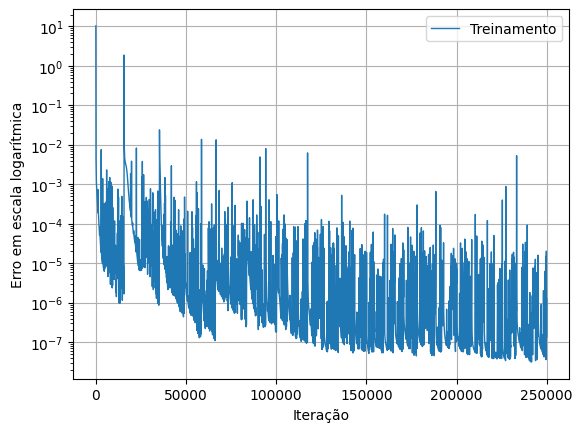

In [41]:
train = np.sum(losshistory.loss_train, axis=1)
test = np.sum(losshistory.loss_test, axis=1)

plt.semilogy(losshistory.steps, train, "-", label="Treinamento", linewidth=1)
# plt.semilogy(losshistory.steps, train, "o-", label="Treinamento", linewidth=2)
# plt.semilogy(losshistory.steps, test, "x-", label="Teste", linewidth=2)

plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")

plt.legend()
plt.grid()
plt.savefig(f"../../images/loss-mono-beta-dfe.png")
plt.show()

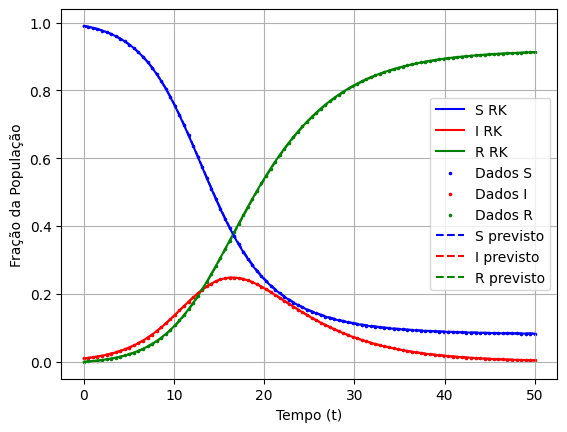

In [42]:
plt.rcParams['text.usetex'] = False
nop_test = 100

test_t = np.linspace(t0, tf, nop_test).reshape(-1, 1)
y_pred = model.predict(test_t)

S_pred, I_pred = y_pred[:, 0], y_pred[:, 1]
R_pred = 1 - S_pred - I_pred  

sir_test = sir_sol.sol(test_t.reshape(nop_test)).T

S_real = sir_test[:,0]
I_real = sir_test[:,1]
R_real = sir_test[:,2]

plt.plot(train_t, S_real, label="S RK", color="blue")
plt.plot(train_t, I_real, label="I RK", color="red")
plt.plot(train_t, R_real, label="R RK", color="green")

plt.scatter(train_t, sir_data[:,0], label="Dados S", color="blue", s=2.5)
plt.scatter(train_t, sir_data[:,1], label="Dados I", color="red", s=2.5)
plt.scatter(train_t, sir_data[:,2], label="Dados R", color="green", s=2.5)

plt.plot(test_t, S_pred, label="S previsto", linestyle="--", color="blue")
plt.plot(test_t, I_pred, label="I previsto", linestyle="--", color="red")
plt.plot(test_t, R_pred, label="R previsto", linestyle="--", color="green")

plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")

plt.legend()
plt.grid()
plt.savefig("../../images/predicted-compartments-mono-beta-dfe.png")

plt.show()

[]

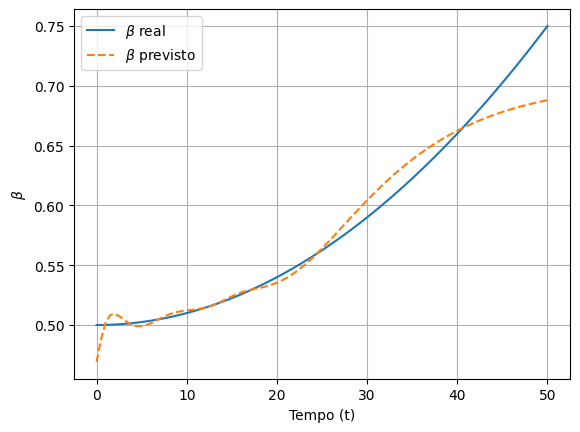

In [43]:
beta_pred = y_pred[:, 2]
beta_real = beta_t(test_t)
plt.plot(test_t, beta_real, label=r"$\beta$ real")
plt.plot(test_t, beta_pred, label=r"$\beta$ previsto", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.legend()
plt.grid()
plt.savefig("../../images/predicted-beta-mono-beta-dfe.png")
plt.plot()

In [44]:
sir_test = sir_sol.sol(test_t.reshape(nop_test)).T

S_real = sir_test[:,0]
I_real = sir_test[:,1]
R_real = 1 - S_real - I_real

### MSE

In [45]:
mean_squared_error(S_real, S_pred)

1.4099676665730935e-06

In [46]:
mean_squared_error(I_real, I_pred)

1.071041055428714e-07

In [47]:
mean_squared_error(R_real, R_pred)

1.8568218030647317e-06

In [48]:
mean_squared_error(beta_real, beta_pred)

0.00028748392780005315

## L2

In [52]:
l2_relative_error(S_real, S_pred)

np.float64(0.0024766250093912817)

In [53]:
l2_relative_error(I_real, I_pred)

np.float64(0.0026831362455408242)

In [54]:
l2_relative_error(R_real, R_pred)

np.float64(0.0020646350310535716)

In [55]:
l2_relative_error(beta_real, beta_pred)

np.float64(1.7256578942358407)

## L-Infinity

In [56]:
np.max(np.abs(S_real - S_pred))

np.float64(0.002392429355637382)

In [57]:
np.max(np.abs(I_real - I_pred))

np.float64(0.0009472606775699499)

In [58]:
np.max(np.abs(R_real - R_pred))

np.float64(0.002521292567329525)

In [59]:
np.max(np.abs(beta_real - beta_pred))

np.float64(0.2808503472727147)